In [63]:
import os
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
import math
from tqdm import tnrange, tqdm_notebook
from time import sleep, time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#%matplotlib inline

warnings.filterwarnings('ignore')
HOLDOUT = 10
r = 0.01
os.chdir("C:\\Users\\ADM\\Desktop\\PIC\\FPCA_Genetico\\FPCA_Genetico\\")
os.getcwd()

'C:\\Users\\ADM\\Desktop\\PIC\\FPCA_Genetico\\FPCA_Genetico'

In [3]:
def CarregarYaleFaces():
    files = glob.glob("databases/yalefaces/*")
    images_yale = [np.array(imageio.mimread(file))[0] for file in files]
    images_yale_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images_yale]
    images_yale_resized = np.array(images_yale_resized)
    images_yale_flatten = [image.flatten() for image in images_yale_resized]
    images_yale_flatten = np.array(images_yale_flatten)
    #print('#Amostras (n): '+str(images_yale_flatten.shape[0]))
    #print('#Features (m): '+str(images_yale_flatten.shape[1]))
    Y = [f.split('.')[0] for f in files]
    return images_yale_flatten, Y

In [4]:
def CarregarAtt():
    folders = glob.glob("databases/att_faces/*")
    images_att = []
    Y = []
    
    for f in folders:
        files = glob.glob(f+"/*")
        #images = [np.array(imageio.mimread(file))[0] for file in files]
        images = [cv2.imread(file,-1)[0] for file in files]
        images_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images]
        #mages_resized = np.array(images_resized)
        images_flatten = [image.flatten() for image in images_resized]
        #mages_flatten = np.array(images_flatten)
        images_att.extend(images_flatten)
        Y.extend([f] * 10)
    return np.array(images_att), Y
    #return folders

In [5]:
def CarregarSheffield():
    folders = glob.glob("databases/sheffield/cropped/*")
    images_sheffield = []
    Y = []
    
    for f in folders:
        files = glob.glob(f+"/face/*")
        images = [cv2.imread(file,-1)[0] for file in files]
        images_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images]
        images_flatten = [image.flatten() for image in images_resized]
        images_sheffield.extend(images_flatten)
        Y.extend([f] * len(files))
    return np.array(images_sheffield), Y

In [7]:
def CarregarAR():
    folders = glob.glob("databases/AR/*")
    images_ar = []
    Y = []
    
    for f in folders:
        files = glob.glob(f+"/*")
        #images = [np.array(imageio.mimread(file))[0] for file in files]
        images = [cv2.imread(file,-1)[0] for file in files]
        images_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images]
        #mages_resized = np.array(images_resized)
        images_flatten = [image.flatten() for image in images_resized]
        #mages_flatten = np.array(images_flatten)
        images_ar.extend(images_flatten)
        Y.extend([f] * 26)
    return np.array(images_ar), Y

In [9]:
def CarregarGeorgiaTech():
    folders = glob.glob("databases/georgia_tech/*")
    images_georgia_tech = []
    Y = []
    
    for f in folders:
        files = glob.glob(f+"/*")
        #images = [np.array(imageio.mimread(file))[0] for file in files]
        images = [cv2.imread(file,-1)[0] for file in files]
        images_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images]
        #mages_resized = np.array(images_resized)
        images_flatten = [image.flatten() for image in images_resized]
        #mages_flatten = np.array(images_flatten)
        images_georgia_tech.extend(images_flatten)
        Y.extend([f] * 15)
    return np.array(images_georgia_tech), Y

In [10]:
def CarregarFaces95():
    folders = glob.glob("databases/faces95/*")
    images_faces95 = []
    Y = []
    
    for f in folders:
        files = glob.glob(f+"/*")
        #images = [np.array(imageio.mimread(file))[0] for file in files]
        images = [cv2.imread(file,-1)[0] for file in files]
        images_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images]
        #mages_resized = np.array(images_resized)
        images_flatten = [image.flatten() for image in images_resized]
        #mages_flatten = np.array(images_flatten)
        images_faces95.extend(images_flatten)
        Y.extend([f] * 20)
    return np.array(images_faces95), Y

In [11]:
print(CarregarYaleFaces()[0].shape)
print(CarregarAtt()[0].shape)
print(CarregarSheffield()[0].shape)
print(CarregarFaces95()[0].shape)
print(CarregarGeorgiaTech()[0].shape)
print(CarregarAR()[0].shape)

(165, 644)
(400, 644)
(575, 644)
(1440, 644)
(750, 644)
(2600, 644)


In [12]:
def F_Eigenfaces(X, W, k, r):
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    D = np.zeros((n, n))
    for j in range(m):
        a = np.power(X[:,j], r) - np.power(X[:,j].mean(), r)
        a = a.reshape(n,1)
        b = a.T
        D = D + (a * b)
    val, vec = np.linalg.eig(D)
    val = np.abs(val)
    vec_c = 1. / np.power((n * val), 0.5)
    vec_c = vec_c * (np.power(X, r) - np.power(mean,r)).T.dot(vec)
    X_ = vec_c.T.dot((np.power(X,r) - np.power(mean,r)).T)
    X__ = vec_c.T.dot((np.power(W,r) - np.power(mean,r)).T)
    return X_.T[:,:k], X__.T[:,:k]

In [13]:
def F_Eigenfaces2(X, W, k, R):
    r = 0.01
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    D = np.zeros((n, n))
    for j in range(m):
        a = np.power(X[:,j], r) - np.power(X[:,j].mean(), r)
        a = a.reshape(n,1)
        b = a.T
        D = D + (a * b)
    val, vec = np.linalg.eig(D)
    val = np.abs(val)
    vec_c = 1. / np.power((n * val), 0.5)
    vec_c = vec_c * (np.power(X, R) - np.power(mean, R)).T.dot(vec)
    X_ = vec_c.T.dot((np.power(X, R) - np.power(mean, R)).T)
    X__ = vec_c.T.dot((np.power(W, R) - np.power(mean, R)).T)
    return X_.T[:,:k], X__.T[:,:k]

In [14]:
def generate_R(r):
    width = 23
    height = 28
    #M_ = np.random.rand(4)
    
    h = height // 2
    w = width / 2
    
    R1 = h * (math.ceil(w) * r[0:1] + math.floor(w) * r[1:2])
    R2 = h * (math.ceil(w) * r[2:3] + math.floor(w) * r[3:4])
    R = R1 + R2
    
    
    return R

In [15]:
def AvaliarClassificadores2(X_train, X_test, y_train, y_test):
    
    clf_1nn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
    return clf_1nn.score(X_test, y_test) * 100

In [16]:
def ler(filename):
    vetores = []
    f = open(filename,'r')
    strings = f.readlines()
    
    for i in strings:
        vetor_str = i.split(' ')
        vetor_str.pop(-1)
        vetor_flt = []
        for v in vetor_str:
            vetor_flt.append(float(v))
        vetores.append(vetor_flt)
        
    return vetores

In [17]:
def Experimento(X, Y, filename):
    acc = []
    std = []
    
    R = ler(filename)
    
    n_componentes = 1
    
    #for i in tqdm(range(1, 16)):
    for i in tnrange(15, desc='Progresso '):
        
        #print('N Components : %s' %(str(n_componentes)))
            
        #print('# Progresso :'+str(n_componentes)+'/70')
        
        #s_pca = []
        
        s_feig = []
        s_feig_star = []
        
        
        #for j in range(HOLDOUT):
        for j in tqdm_notebook(range(HOLDOUT), desc='Nº c:{0}'.format(n_componentes)):
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state= round(time()) + 15 * j)
            #print(X_train)

            #gerar os conjuntos de treino e teste transformados
            #X_pca_train, X_pca_test  = PCA(X_train, X_test, n_componentes)
            X_feig_train, X_feig_test = F_Eigenfaces(X_train, X_test, n_componentes, r)
            X_feig_star_train, X_feig_star_test = F_Eigenfaces2(X_train, X_test, n_componentes, generate_R(R[i]))
            
            #acuracias
            #s_pca.append(AvaliarClassificadores2(X_pca_train, X_pca_test, y_train, y_test))X_eige_test
            s_feig.append(AvaliarClassificadores2(X_feig_train, X_feig_test, y_train, y_test))
            s_feig_star.append(AvaliarClassificadores2(X_feig_star_train, X_feig_star_test, y_train, y_test))

        #print(s_fpca)
        acc.append([#np.array(s_pca).mean(),
                    np.array(s_feig).mean(),
                    np.array(s_feig_star).mean()])
        
        std.append([#np.std(s_pca),
                    np.std(s_feig) / 100,
                    np.std(s_feig_star) / 100])
        
        if(n_componentes == 1):
            n_componentes += 4
        else:
            n_componentes += 5
            
            sleep(0.01)
        
    return np.array(acc), np.array(std)

In [67]:
def ImprimirResultados(acc, dataset_name):
    
    x = np.arange(0, 15)
    x = x * 5
    x[0] += 1
    #print(len(x))
    #plt.figure(figsize=(20,15))
    plt.title("Dataset: "+dataset_name+" - Classificador: 1-NN")
    #plt.plot(x, acc_yale[:,0], color='black')
    plt.plot(x, acc[:,0], color='red')
    plt.plot(x, acc[:,1], color='blue')
    plt.ylabel('Acuracia media')
    plt.xlabel('Numero de componentes')
    #plt.legend(labels=['PCA','FPCA','Eigenfaces','F Eigenfaces'])
    plt.legend(labels=['F Eigenfaces','F Eigenfaces *'])
    plt.grid()
    #plt.show()

In [19]:
def ImprimirTabela(acc, std):
    i = 1
    for a, s in zip(acc, std):
        print(str(i)+"\t{0:.3f}".format(a[0])+" +-"+"{0:.3f}".format(s[0])+
              "\t\t"+"{0:.3f}".format(a[1])+" +-"+"{0:.3f}".format(s[1]))
        if(i == 1):
            i += 4
        else:
            i += 5

In [20]:
#calculando as acuracias (70 x 4)
print("---Yale---")
X, Y = CarregarYaleFaces()
acc_yale, std_yale = Experimento(X, Y, 'genetico_yale.txt')

---Yale---


HBox(children=(IntProgress(value=0, description='Progresso ', max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:1', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:5', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:10', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:15', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:20', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:25', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:30', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:35', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:40', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:45', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:50', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:55', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:60', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:65', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:70', max=10), HTML(value='')))

In [22]:
#calculando as acuracias (70 x 4)
print("---AT&T---")
X, Y = CarregarAtt()
acc_att, std_att = Experimento(X, Y, 'genetico_att.txt')

---AT&T---


HBox(children=(IntProgress(value=0, description='Progresso ', max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:1', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:5', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:10', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:15', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:20', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:25', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:30', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:35', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:40', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:45', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:50', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:55', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:60', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:65', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:70', max=10), HTML(value='')))

In [24]:
#calculando as acuracias (70 x 4)
print("---Sheffield---")
X, Y = CarregarSheffield()
acc_sheffield, std_sheffield = Experimento(X, Y, 'genetico_sheffield.txt')

---Sheffield---


HBox(children=(IntProgress(value=0, description='Progresso ', max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:1', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:5', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:10', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:15', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:20', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:25', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:30', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:35', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:40', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:45', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:50', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:55', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:60', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:65', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:70', max=10), HTML(value='')))

In [26]:
#calculando as acuracias (70 x 4)
print("---Georgia Tech---")
X, Y = CarregarGeorgiaTech()
acc_gtech, std_gtech = Experimento(X, Y, 'genetico_georgia_tech.txt')

---Georgia Tech---


HBox(children=(IntProgress(value=0, description='Progresso ', max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:1', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:5', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:10', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:15', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:20', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:25', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:30', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:35', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:40', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:45', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:50', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:55', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:60', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:65', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:70', max=10), HTML(value='')))

In [28]:
#calculando as acuracias (70 x 4)
print("---Faces95---")
X, Y = CarregarSheffield()
acc_faces95, std_faces95 = Experimento(X, Y, 'genetico_faces95.txt')

---Faces95---


HBox(children=(IntProgress(value=0, description='Progresso ', max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:1', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:5', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:10', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:15', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:20', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:25', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:30', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:35', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:40', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:45', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:50', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:55', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:60', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:65', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:70', max=10), HTML(value='')))

In [30]:
#calculando as acuracias (70 x 4)
print("---AR---")
X, Y = CarregarAR()
acc_ar, std_ar = Experimento(X, Y, 'genetico_ar.txt')

---AR---


HBox(children=(IntProgress(value=0, description='Progresso ', max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:1', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:5', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:10', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:15', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:20', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:25', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:30', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:35', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:40', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:45', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:50', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:55', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:60', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:65', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Nº c:70', max=10), HTML(value='')))

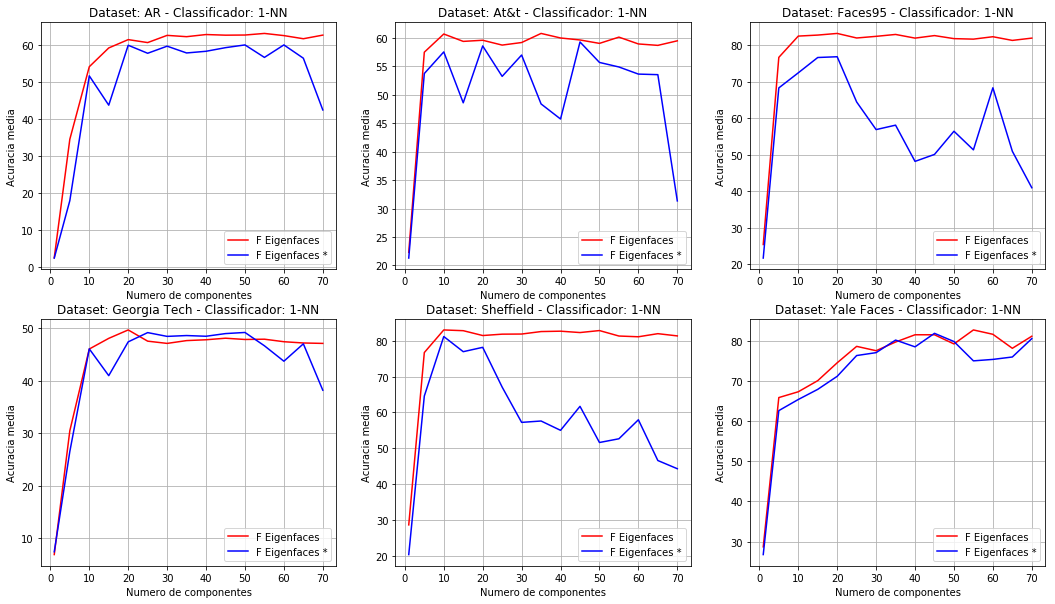

In [69]:
plt.figure(figsize=(18,10))

plt.subplot(231)
ImprimirResultados(acc_ar, "AR")
plt.subplot(232)
ImprimirResultados(acc_att, "At&t")
plt.subplot(233)
ImprimirResultados(acc_faces95, "Faces95")
plt.subplot(234)
ImprimirResultados(acc_gtech, "Georgia Tech")
plt.subplot(235)
ImprimirResultados(acc_sheffield, "Sheffield")
plt.subplot(236)
ImprimirResultados(acc_yale, "Yale Faces")
plt.savefig('resultados.png')

In [66]:
print("\t+--------------------Yale--------------------+")
print("\t-----F Eigenfaces-----------F Eigenfaces-*----")
ImprimirTabela(acc_yale, std_yale)

print("\t---------------------AT&T---------------------")
print("\t-----F Eigenfaces-----------F Eigenfaces-*----")
ImprimirTabela(acc_att, std_att)

print("\t------------------Sheffield-------------------")
print("\t-----F Eigenfaces-----------F Eigenfaces-*----")
ImprimirTabela(acc_sheffield, std_sheffield)

print("\t---------------------AR-----------------------")
print("\t-----F Eigenfaces-----------F Eigenfaces-*----")
ImprimirTabela(acc_ar, std_ar)

print("\t----------------Georgia Tech------------------")
print("\t-----F Eigenfaces-----------F Eigenfaces-*----")
ImprimirTabela(acc_gtech, std_gtech)

print("\t------------------Faces 95--------------------")
print("\t-----F Eigenfaces-----------F Eigenfaces-*----")
ImprimirTabela(acc_faces95, std_faces95)

	+--------------------Yale--------------------+
	-----F Eigenfaces-----------F Eigenfaces-*----
1	28.675 +-0.052		26.747 +-0.041
5	65.904 +-0.036		62.651 +-0.036
10	67.349 +-0.054		65.422 +-0.052
15	70.120 +-0.050		67.952 +-0.053
20	74.578 +-0.049		71.205 +-0.063
25	78.675 +-0.024		76.386 +-0.029
30	77.590 +-0.039		77.108 +-0.041
35	79.759 +-0.049		80.241 +-0.037
40	81.566 +-0.033		78.554 +-0.039
45	81.566 +-0.037		81.928 +-0.024
50	79.277 +-0.046		79.880 +-0.030
55	82.771 +-0.030		75.060 +-0.032
60	81.687 +-0.048		75.422 +-0.040
65	78.193 +-0.036		76.024 +-0.038
70	81.205 +-0.057		80.602 +-0.050
	---------------------AT&T---------------------
	-----F Eigenfaces-----------F Eigenfaces-*----
1	22.300 +-0.043		21.300 +-0.028
5	57.500 +-0.034		53.750 +-0.046
10	60.700 +-0.028		57.550 +-0.025
15	59.400 +-0.036		48.600 +-0.037
20	59.600 +-0.033		58.600 +-0.018
25	58.750 +-0.027		53.250 +-0.061
30	59.200 +-0.033		57.000 +-0.057
35	60.800 +-0.037		48.400 +-0.061
40	60.000 +-0.022		45.750 +-0.

In [48]:
#salvando as acuracias dos classificadores
acc_general = [acc_ar, acc_gtech, acc_faces95, acc_yale, acc_att, acc_sheffield]

folder = 'acc'
datasets = ['ar', 'georgia_tech', 'faces95', 'yale_faces', 'att', 'sheffield']
for d,acc in zip(datasets, acc_general):
    filename1 = folder+'\\acc_'+d+'_eigenfaces.csv'
    np.savetxt(filename1, acc[:,0], delimiter=',')
    np.savetxt(folder+'\\acc_'+d+'_eigenfaces_proposed.csv', acc[:,1], delimiter=',')